In [1]:
#HOW TO SOLVE THE Scipy ERROR IN PYTHON 3, SEE ON CELL NO 7 SOLUTION
!git clone https://github.com/niazwazir/SRCNN-Keras.git

Cloning into 'SRCNN-Keras'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 81 (delta 2), reused 0 (delta 0), pack-reused 72
Unpacking objects: 100% (81/81), done.


In [2]:
cd SRCNN-Keras

/content/SRCNN-Keras


In [3]:
!unzip yang91.zip

Archive:  yang91.zip
   creating: yang91/
  inflating: yang91/tt9.bmp          
  inflating: yang91/tt8.bmp          
  inflating: yang91/tt7.bmp          
  inflating: yang91/tt6.bmp          
  inflating: yang91/tt5.bmp          
  inflating: yang91/tt4.bmp          
  inflating: yang91/tt3.bmp          
  inflating: yang91/tt27.bmp         
  inflating: yang91/tt26.bmp         
  inflating: yang91/tt25.bmp         
  inflating: yang91/tt24.bmp         
  inflating: yang91/tt23.bmp         
  inflating: yang91/tt22.bmp         
  inflating: yang91/tt21.bmp         
  inflating: yang91/tt20.bmp         
  inflating: yang91/tt2.bmp          
  inflating: yang91/tt19.bmp         
  inflating: yang91/tt18.bmp         
  inflating: yang91/tt17.bmp         
  inflating: yang91/tt16.bmp         
  inflating: yang91/tt15.bmp         
  inflating: yang91/tt14.bmp         
  inflating: yang91/tt13.bmp         
  inflating: yang91/tt12.bmp         
  inflating: yang91/tt10.bmp         
  inflat

In [4]:
!ls

baby_GT.bmp
baby_x2_GT.png
bird_GT.bmp
butterfly_GT.bmp
head_GT.bmp
Image_Super_Resolution.ipynb
MOUNT_SRCNN_37_PSNR.ipynb
prepare_data.py
project.gif
PSNR_SSIM_MSE_SRCNN_Super_Resolution_.ipynb
SRCNN_COLOR_IMAGE_GENERATED.ipynb
SRCNN_KERAS_2nd.ipynb
SRCNN_KERAS_IN_Python3_Curves.ipynb
SRCNN_KERAS_IN_Python3.ipynb
SRCNN_KERAS.ipynb
SRCNNMODIFIEDPYTHON2.ipynb
subpixel.py
text
woman_GT.bmp
yang91
yang91.zip


In [5]:
import matplotlib.pyplot as plt, glob
import tensorflow.keras as K
import cv2
import numpy as np

In [6]:
input_size=128
scale = 2
batch_size=16

In [7]:
train_list = glob.glob('yang91/*.*', recursive=True)
n = len(train_list); n

63

In [8]:
val_list = glob.glob('yang91/*.*', recursive=True)
len(val_list)

63

## Super Resolution Model

In [9]:
def conv_block(x, filters, kernel, stride=(1,1), mode='same', act=True):
    x = K.layers.Conv2D(filters, kernel_size=kernel, strides=stride, padding=mode)(x)
    return K.layers.Activation('relu')(x) if act else x

In [10]:
def res_block(ip,nf=16):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return K.layers.Add()([x,ip])

In [11]:
def up_block(x,nf):
    x = K.layers.UpSampling2D()(x)
    x = conv_block(x,nf,kernel=(1,1))
    return x

In [12]:
def get_srmodel(shape=(None,None,3)):
    inp=K.Input(shape)

    x=conv_block(inp, 16, 3, (1,1))
    for i in range(5): x=res_block(x,16)
    

    x=up_block(x,nf=32)
#     for i in range(2): x=res_block(x,32)

#     x=up_block(x,nf=64)
#     for i in range(1): x=res_block(x,64)
    
    x = K.layers.Conv2D(3,(3,3),padding='same')(x)
    return inp,x

In [13]:
inp,outp=get_srmodel((None,None,3))
Wazir_model=K.Model(inp,outp)
Wazir_model.summary(110)

Model: "model"
______________________________________________________________________________________________________________
 Layer (type)                       Output Shape            Param #      Connected to                         
 input_1 (InputLayer)               [(None, None, None, 3)  0            []                                   
                                    ]                                                                         
                                                                                                              
 conv2d (Conv2D)                    (None, None, None, 16)  448          ['input_1[0][0]']                    
                                                                                                              
 activation (Activation)            (None, None, None, 16)  0            ['conv2d[0][0]']                     
                                                                                                 

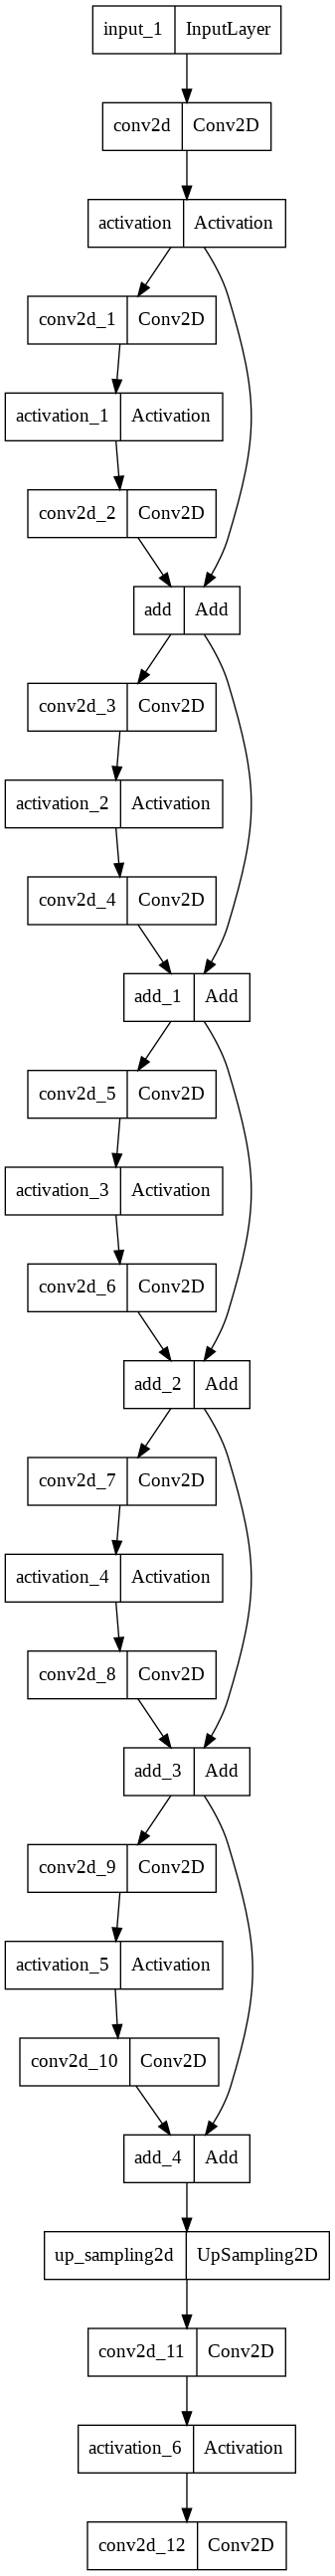

In [14]:
import keras
import tensorflow as tf
tf.keras.utils.plot_model(Wazir_model, 'Wazir_first1_model.png')

In [15]:
def randomHorizontalFlip(img, u=0.5):
    if np.random.random() < u:
        img = cv2.flip(img, 1)
    return img
def randomVerticalFlip(img, u=0.5):
    if np.random.random() < u:
        img = cv2.flip(img, 0)
    return img

In [16]:
def randomCrop(img):
    global input_size
    h=input_size*2
    assert img.shape[0] >= h
    assert img.shape[1] >= h
    x = random.randint(0, img.shape[1] - h)
    y = random.randint(0, img.shape[0] - h)
    img = img[y:y+h, x:x+h]
    return img

In [17]:
def train_generator():
    global batch_size
    global input_size
    while True:
        for start in range(0, len(train_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(train_list))
            ids_train_batch = train_list[start:end]
            for i,ids in enumerate(ids_train_batch):
                img = cv2.imread(ids)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                tar = cv2.resize(img, (input_size*2, input_size*2),interpolation=cv2.INTER_CUBIC)  #####
                tar = randomHorizontalFlip(tar)
                tar = randomVerticalFlip(tar)
                img1 = cv2.resize(tar, (input_size, input_size),interpolation=cv2.INTER_CUBIC)
                x_batch.append(img1)
                y_batch.append(tar)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch

# i am using Set5 dataset for validation please download the data
def valid_generator():
    global batch_size
    global input_size
    while True:
        for start in range(0, len(val_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(val_list))
            ids_valid_batch = val_list[start:end]            
            for i,ids in enumerate(ids_valid_batch):
                img = cv2.imread(ids)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img1 = cv2.resize(img, (input_size, input_size),interpolation=cv2.INTER_CUBIC)
                img2 = cv2.resize(img, (input_size*2, input_size*2),interpolation=cv2.INTER_CUBIC)
                x_batch.append(img1)
                y_batch.append(img2)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch

In [18]:
l=next(valid_generator())

In [35]:
def wazir_loss(y_true, y_pred):
    squared_difference = tf.square((y_true - y_pred)+0.01)
    return tf.reduce_mean(squared_difference, axis=-1)

In [36]:
import tensorflow.keras.backend as K

In [37]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))

In [38]:
def L1_Charbonnier_loss(y_true, y_pred):
    """L1 Charbonnierloss."""
    eps = 1e-6
    y_true = tf.convert_to_tensor(y_true, np.float32)
    y_pred = tf.convert_to_tensor(y_pred, np.float32)
    diff = y_true-y_pred
    error = K.sqrt( diff * diff + eps )
    loss = K.sum(error) 
    return loss

In [39]:
def psnr(y_true,y_pred):
    return tf.image.psnr(y_true,y_pred,1.0)
def ssim(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)
def mean_squared_error(y_true, y_pred):
    return tf.keras.metrics.mean_squared_error(y_true, y_pred)

In [40]:
learning_rate=0.001
adam=tf.optimizers.Adam(lr=learning_rate)
Wazir_model.compile(optimizer=adam,loss='mse',metrics=[psnr,ssim,mean_squared_error,wazir_loss,charbonnier_loss])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [46]:
def fit(model,epoch=5):
    model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(len(train_list)) / float(batch_size)),
                    epochs=epoch,
                    verbose=1,
                    validation_data=valid_generator(),
                    shuffle=True,
                    validation_steps=np.ceil(float(len(val_list)) / float(batch_size)))
    return model

In [49]:
Wazir_model=fit(Wazir_model,15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/15
4/4 [==============================] - 1s 403ms/step - loss: 0.0020 - psnr: 28.3237 - ssim: 0.8449 - mean_squared_error: 0.0020 - wazir_loss: 0.0021 - charbonnier_loss: 0.0291 - val_loss: 0.0023 - val_psnr: 27.9454 - val_ssim: 0.8368 - val_mean_squared_error: 0.0023 - val_wazir_loss: 0.0023 - val_charbonnier_loss: 0.0304
Epoch 2/15
4/4 [==============================] - 1s 380ms/step - loss: 0.0020 - psnr: 28.3643 - ssim: 0.8474 - mean_squared_error: 0.0020 - wazir_loss: 0.0021 - charbonnier_loss: 0.0290 - val_loss: 0.0022 - val_psnr: 27.9619 - val_ssim: 0.8367 - val_mean_squared_error: 0.0022 - val_wazir_loss: 0.0022 - val_charbonnier_loss: 0.0303
Epoch 3/15
4/4 [==============================] - 1s 348ms/step - loss: 0.0019 - psnr: 28.4936 - ssim: 0.8487 - mean_squared_error: 0.0019 - wazir_loss: 0.0020 - charbonnier_loss: 0.0285 - val_loss: 0.0023 - val_psnr: 27.9513 - val_ssim: 0.8399 - val_mean_squared_error: 0.0023 - val_wazir_loss: 0.0023 - val_charbonnier_loss: 0.030

In [55]:
Wazir_model=fit(Wazir_model,5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
4/4 [==============================] - 4s 623ms/step - loss: 0.0426 - psnr: 14.4399 - ssim: 0.4236 - mean_squared_error: 0.0426 - wazir_loss: 0.0426 - L1_Charbonnier_loss: 499701.7500 - val_loss: 0.0354 - val_psnr: 15.0788 - val_ssim: 0.4610 - val_mean_squared_error: 0.0354 - val_wazir_loss: 0.0354 - val_L1_Charbonnier_loss: 463792.1562
Epoch 2/5
4/4 [==============================] - 2s 443ms/step - loss: 0.0288 - psnr: 15.9822 - ssim: 0.4787 - mean_squared_error: 0.0288 - wazir_loss: 0.0288 - L1_Charbonnier_loss: 402833.5312 - val_loss: 0.0180 - val_psnr: 18.1811 - val_ssim: 0.5209 - val_mean_squared_error: 0.0180 - val_wazir_loss: 0.0180 - val_L1_Charbonnier_loss: 308131.9375
Epoch 3/5
4/4 [==============================] - 2s 440ms/step - loss: 0.0185 - psnr: 17.9188 - ssim: 0.5323 - mean_squared_error: 0.0185 - wazir_loss: 0.0185 - L1_Charbonnier_loss: 319907.5000 - val_loss: 0.0160 - val_psnr: 18.3984 - val_ssim: 0.5425 - val_mean_squared_error: 0.0160 - val_wazir_loss: